# Testing Notebook

This notebook tests the active learning functionality of the developed GP package.

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

# Test Function

We select the following test function in this case study:

\begin{equation}
y(x) = 3(1-x)^2e^{(-x^2-1)}-10(0.2x-x^3)e^{-x^2}, \; x \in [-4, 1]
\end{equation}

Later on, we will train a Gaussian Process model to approximate this test function. To minimize the number of employed training samples, we will use an active learning strategy to intelligiently select one new sample at each learning iteration. Details of the active learning workflow is given in a latter section. 

For now, let's first plot this function to gain some intuition.

In [2]:
def test_function(x):
    y = 3*(1-x)**2*np.exp(-x**2-1) \
            - 10*(0.2*x-x**3)*np.exp(-x**2)
    return y

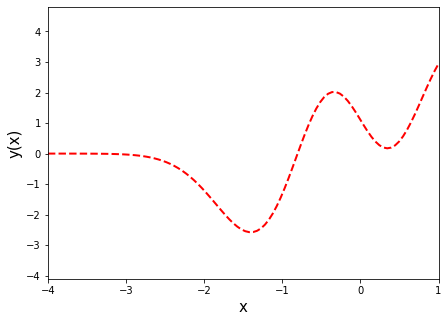

In [26]:
# Test function values
X_test = np.linspace(-4, 1, 100).reshape(-1,1)
y_test = test_function(X_test)
            

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-4,1]);
ax.set_ylim([-4.1,4.8]);

From the figure above, we can see that the current test function describes a rather complex relationship between the input $x$ and the output $y(x)$: a flat region exists in the range [-4, -3], while multimodal responses dominate the remaining region. Since the correlation length varies significantly across the parameter space, it is challenging to construct a globally accurate Gaussian Process model.

# Case study

## 1. Train an initial model

We start by training an initial GP model with 5 samples spreading evenly across the parameter space. Here, the GP implementation from Scikit-learn is adopted to train the GP model.

In [17]:
# Initial training data
X_train = np.linspace(-4, 1, 5).reshape(-1,1)
y_train = 3*(1-X_train)**2*np.exp(-X_train**2-1) \
            - 10*(0.2*X_train-X_train**3)*np.exp(-X_train**2)

In [18]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x000001D3560A06D0>)])

In [27]:
# GP prediction
y_pred, y_pred_SSqr = pipe.predict(X_test)

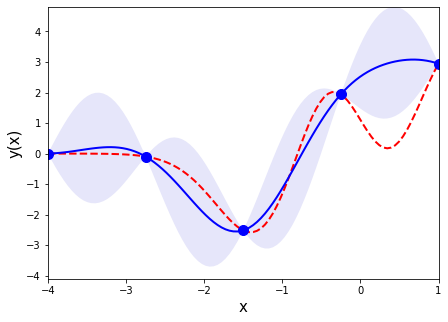

In [28]:
# Check GP prediction accuracy
X_test = X_test.flatten()
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.fill_between(X_test, y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
fig

As can be seen from the figure above, the GP predictions match poorly with the true test function due to an insufficient number of training samples. In the following, we will adopt the active learning strategy discussed above to gradually enrich the training dataset and refine the GP model.

## 2. First iteration

Before we start iterating, we need to generate a pool of candidate samples. We will maintain this candidate pool for the subsequent iterations. At each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected prediction error value among all the candidate samples.

In [31]:
Candidate = np.linspace(-4, 1, 1000).reshape(-1,1)
Candidate_normalized = pipe['scaler'].transform(Candidate)

Now we are ready for the first iteration. 

In [32]:
sample_index = pipe['GP'].enrichment('EPE', 
                                     candidate=Candidate_normalized, 
                                     diagnose=False)

NameError: name 'EPE' is not defined

In [61]:
# Calculate leave-one-out CV error for all training samples
LOOCV = (-1)*cross_val_score(model, X_train, y_train, 
                             cv=X_train.shape[0],
                            scoring='neg_mean_squared_error')

In [62]:
# Calculate expected prediction errors (EPE)
EPE = np.zeros_like(X_candidate)  
EPE_history = []      # Record the maximum EPE convergence history

for i,candidate in enumerate(X_candidate):
    
    # Calculate prediction variance
    prediction, prediction_std = model.predict([candidate], return_std=True)
    predict_var = prediction_std**2
    
    # Calculate prediction bias
    index = np.argmin(np.abs(candidate-X_train))
    bias = LOOCV[index]
    
    # Calculate EPE
    EPE[i] = predict_var+bias
    
EPE_history.append(np.max(EPE))

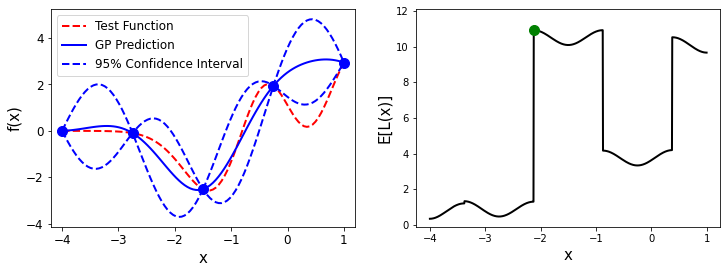

In [63]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

# GP prediction
axs[0].plot(X_test,y_test,'r--',lw=2,label='Test Function')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
axs[0].plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
axs[0].plot(X_test,y_pred+1.96*pred_std.reshape(-1,1),'b--',
            lw=2,label='95% Confidence Interval')
axs[0].plot(X_test,y_pred-1.96*pred_std.reshape(-1,1),'b--',lw=2)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2,1.2]);

# EPE 
axs[1].plot(X_candidate,EPE,'k-',lw=2)
axs[1].plot(X_candidate[np.argmax(EPE)],np.max(EPE),'go',markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1,12.1]);
fig.savefig('./images/First_iteration.png')

On the right, we can see the distribution of $E[L(x)]$ across the parameter space. The largest expected prediction error occurs at $x^{\ast}=-2.12$ (marked as a green dot). Therefore, in this first iteration, we pick $x^{\ast}=-2.12$ as the sample to enrich the current training dataset and update the GP model.

In [64]:
# Enrich training dataset
X_train = np.vstack((X_train, X_candidate[np.argmax(EPE)]))
y_train = np.vstack((y_train, test_function(X_candidate[np.argmax(EPE)])))

In [65]:
y_train

array([[-0.  ],
       [-0.1 ],
       [-2.51],
       [ 1.94],
       [ 2.94],
       [-0.89]])

In [66]:
# Update GP model
model.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=30, normalize_y=True)

In [67]:
# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

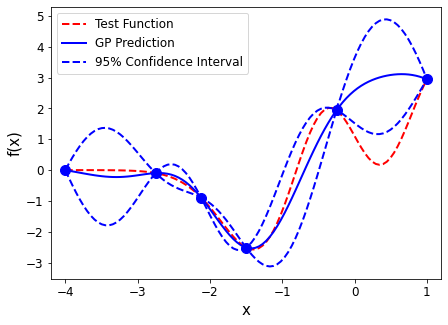

In [68]:
# Post-processing
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',lw=2,label='Test Function')
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
ax.plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
ax.plot(X_test,y_pred+1.96*pred_std.reshape(-1,1),'b--',
            lw=2,label='95% Confidence Interval')
ax.plot(X_test,y_pred-1.96*pred_std.reshape(-1,1),'b--',lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12})
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_xlim([-4.2,1.2]);

Thus, we have completed the first iteration.

## 3. Further iterations

First, we define a `EPE_Learning` function to calculate expected prediction error values.

In [69]:
# Expected prediction error-based active learning function
def EPE_learning(candidates, model):
    """Active learning function based on expected prediction error
    
        This function selects a new sample from candidate pool to enrich the current training 
        dataset. The sample gets selected if it has the maximum expected prediction error.
    
        Input:
        - candidates: pool of candidates to select sample from
        - model: the up-to-date GP model
        
        Output:
        - EPE: the expected prediction error
    """
    
    # Calculate leave-one-out CV errors
    LOOCV = (-1)*cross_val_score(model, model.X_train_, model.y_train_, 
                             cv=model.X_train_.shape[0],
                            scoring='neg_mean_squared_error')
    
    # Initiate EPE array
    EPE = np.zeros_like(candidates)  
    
    for i,candidate in enumerate(candidates):
        
        # Calculate prediction variance
        prediction, prediction_std = model.predict([candidate], return_std=True)
        predict_var = prediction_std**2
        
        # Calculate prediction bias        
        index = np.argmin(np.abs(candidate-model.X_train_))
        bias = LOOCV[index]
        
        # Calculate EPE
        EPE[i] = predict_var+bias
        
    return EPE

Then, we can start iterating.

In [70]:
# Active learning: iterations
iteration = 2

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [88]:
# 1-GP model training and predicting
model.fit(X_train, y_train)
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)
mse_score = np.round(mean_squared_error(y_test, y_pred),4)

# 2-Calculating EPE
EPE = EPE_learning(X_candidate, model)
EPE_history.append(np.max(EPE))

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(np.max(EPE))) \
                    + os.linesep \
                    + 'Located at {}'.format(str(X_candidate[np.argmax(EPE)])) \
                    + os.linesep \
                    + 'Current MSE is {}'.format(str(mse_score))

print(Iteration_summary)

Iteration 8:
Current max EPE is 0.25152081194802833
Located at [-0.56]
Current MSE is 0.0


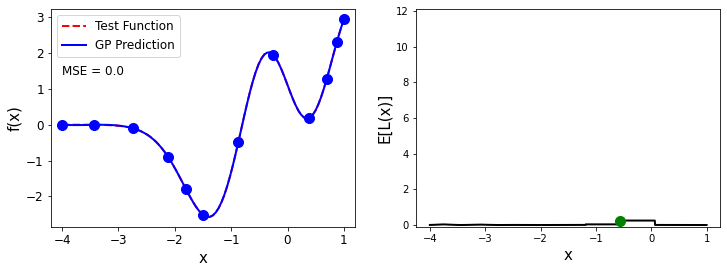

In [89]:
# 4-Iteration assessment
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(X_test,y_test,'r--',lw=2,label='Test Function')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
axs[0].plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
axs[0].text(-4, 1.4, 'MSE = {}'.format(str(mse_score)), fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2,1.2]);

axs[1].plot(X_candidate,EPE,'k-',lw=2)
axs[1].plot(X_candidate[np.argmax(EPE)],np.max(EPE),'go',markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1,12.1]);
fig.savefig('./images/Further_iteration.png')

# 5-Enrich training dataset
X_train = np.vstack((X_train, X_candidate[np.argmax(EPE)]))
y_train = np.vstack((y_train, test_function(X_candidate[np.argmax(EPE)])))
iteration += 1

After 7 iterations, we can see that the maximum $E[L(x)]$ value has dropped a lot compared with the first iteration. Correspondingly, this GP model is able to make accurate predictions across the entire parameter space. 

In practice, we monitor the change of maximum $E[L(x)]$ to define when the training can be terminated. In the current case study, we require that the maximum $E[L(x)]$ has to be smaller than 5% of the maximum $E[L(x)]$ at the first iteration.

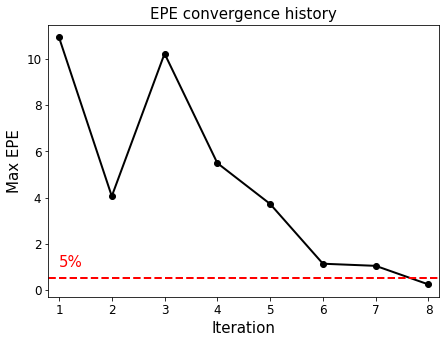

In [95]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

total_iteration = np.arange(1,iteration)
ax.plot(total_iteration, EPE_history, 'k-o', lw=2)
ax.plot([0,8.3],[EPE_history[0]*0.05, EPE_history[0]*0.05],'r--',lw=2)
ax.text(1,1,'5%',fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 8.2]);
fig.savefig('./images/EPE_evolution.png')